In [21]:
import pandas as pd
import numpy as np

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Embedding, SpatialDropout1D, LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Activation, Dropout
# import LabelEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from matplotlib import pyplot as plt

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.metrics import classification_report, confusion_matrix
#test train split
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter


In [6]:
df = pd.read_csv('cleaned_dataset.csv')
df.columns

Index(['type', 'posts', 'cleaned_posts'], dtype='object')

In [77]:
def graph_plots(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.savefig(string + '.png')
  plt.show()

In [7]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df['cleaned_posts'])
tokenizer.word_index # Get our learned vocabulary
word_index = tokenizer.word_index

VOCAB_SIZE = len(word_index)+1 # Total words

In [8]:
X = tokenizer.texts_to_sequences(df['cleaned_posts'])
MAX_SEQ_LENGTH = max(len(seq) for seq in X)
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen= MAX_SEQ_LENGTH, padding = 'post') # Pad the sequence to the same length to make it uniform

In [63]:
from gensim.models import Word2Vec, KeyedVectors

gn_vec_zip_path ="/Users/salmazainana/Downloads/GoogleNews-vectors-negative300.bin"
model = KeyedVectors.load_word2vec_format(gn_vec_zip_path, binary=True)


In [64]:
word2vec_model = model

In [65]:
embedding_size = 300
embedding_matrix = np.zeros((VOCAB_SIZE, embedding_size))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model:  # Use word2vec_model directly instead of word2vec_model.wv
        embedding_vector = word2vec_model[word]  # Same here
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [66]:
y = df['type']
#one hote encode the target variable such that ENTJ = [1,0,0,0], INTJ = [0,0,0,0], ENTP = [1,0,0,1], ect 
#dichotomy classification
# strip letter from the type so ['ENTJ'] becomes ['E','N','T','J']
y_stripped = y.apply(lambda x: list(x.strip()))

def preprocessing(y):
    if y[0] == 'E':
        y[0] = 1
    else:
        y[0] = 0
    if y[1] == 'N':
        y[1] = 1
    else:
        y[1] = 0
    if y[2] == 'T':
        y[2] = 1
    else:
        y[2] = 0
    if y[3] == 'J':
        y[3] = 1
    else:
        y[3] = 0

    return y 

y = y_stripped.apply(preprocessing)
y = np.array(y.tolist())
type(y)


numpy.ndarray

In [67]:
# model_path = "/Users/zainanasalma/Desktop/stanford/courses/CS229/mbti-cs229/Word2vec_model.model"
# #load model from model_path
# word2vec_model = tf.keras.models.load_model(model_path)

embedding_size = 300
# embedding_matrix = np.zeros((VOCAB_SIZE, embedding_size))

# for word, i in tokenizer.word_index.items():
#     if word in word2vec_model.wv:
#         embedding_vector = word2vec_model.wv[word]
#         if embedding_vector is not None:
#             embedding_matrix[i] = embedding_vector




In [68]:
rate = 0.1
n_classes=4

model = Sequential()
#model.add(Embedding(VOCAB_SIZE, embedding_size, input_length=MAX_SEQ_LENGTH, weights=[embedding_matrix], trainable=False))
model.add(Embedding(VOCAB_SIZE, embedding_size, input_length=MAX_SEQ_LENGTH, trainable=False))
model.add(SimpleRNN(100))
model.add(Dropout(rate))
model.add(Dense(n_classes, activation='sigmoid'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 957, 300)          40590900  
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100)               40100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 4)                 404       
                                                                 
Total params: 40631404 (155.00 MB)
Trainable params: 40504 (158.22 KB)
Non-trainable params: 40590900 (154.84 MB)
_________________________________________________________________


In [69]:

#Train model 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train, 
          epochs=10, 
          batch_size=64, 
          validation_data=(X_test, y_test), 
          callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/10
109/109 [==============================] - 62s 570ms/step - loss: 2.6934 - accuracy: 0.6006 - val_loss: 2.5219 - val_accuracy: 0.6548
Epoch 2/10
109/109 [==============================] - 52s 476ms/step - loss: 2.7236 - accuracy: 0.5988 - val_loss: 2.5346 - val_accuracy: 0.6548
Epoch 3/10
109/109 [==============================] - 58s 535ms/step - loss: 2.7124 - accuracy: 0.6026 - val_loss: 2.5546 - val_accuracy: 0.6542
Epoch 4/10
109/109 [==============================] - 58s 535ms/step - loss: 2.7296 - accuracy: 0.5993 - val_loss: 2.5466 - val_accuracy: 0.6536


In [70]:

#save model as 4class rnn model
model_path = "4class_w2v_model.model"
model.save(model_path)

INFO:tensorflow:Assets written to: 4class_w2v_model.model/assets


INFO:tensorflow:Assets written to: 4class_w2v_model.model/assets


55/55 [==============================] - 19s 356ms/step
AUC for task 0: 0.5
AUC for task 1: 0.5
AUC for task 2: 0.5
AUC for task 3: 0.5


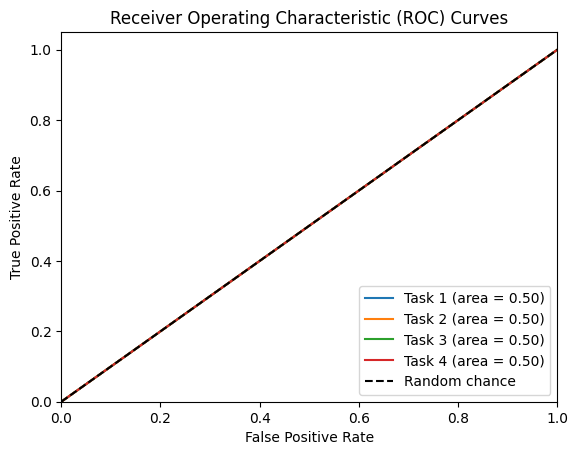

Average AUC: 0.5


In [82]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

y_pred = model.predict(X_test)
n_classes = y_test.shape[1]  # Make sure n_classes is defined

# Calculate AUC for each binary classification task and plot ROC curves
auc_scores = []

for i in range(n_classes):
    score = roc_auc_score(y_test[:, i], y_pred[:, i])  # Use a different variable name
    auc_scores.append(score)
    print(f"AUC for task {i}: {score}")

    fpr, tpr, thresholds = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)  
    plt.plot(fpr, tpr, label=f'Task {i+1} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

# Calculate the average AUC across all tasks
average_auc = np.mean(auc_scores)
print(f"Average AUC: {average_auc}")


#one LSTM for 4binary class

In [72]:
#One LSTM 

model = Sequential()
model.add(Embedding(VOCAB_SIZE, embedding_size, weights=[embedding_matrix], input_length=MAX_SEQ_LENGTH, trainable=False))
model.add(SpatialDropout1D(0.8))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [73]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 957, 300)          40590900  
                                                                 
 spatial_dropout1d_3 (Spati  (None, 957, 300)          0         
 alDropout1D)                                                    
                                                                 
 lstm_3 (LSTM)               (None, 100)               160400    
                                                                 
 dense_5 (Dense)             (None, 4)                 404       
                                                                 
Total params: 40751704 (155.46 MB)
Trainable params: 160804 (628.14 KB)
Non-trainable params: 40590900 (154.84 MB)
_________________________________________________________________


In [75]:
#Train model 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
history = model.fit(X_train, y_train, 
          epochs=30, 
          batch_size=64, 
          validation_data=(X_test, y_test), 
          callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/30
109/109 [==============================] - 353s 3s/step - loss: 2.8151 - accuracy: 0.6561 - val_loss: 2.6855 - val_accuracy: 0.6594
Epoch 2/30
109/109 [==============================] - 343s 3s/step - loss: 2.7699 - accuracy: 0.6561 - val_loss: 2.7024 - val_accuracy: 0.6594
Epoch 3/30
109/109 [==============================] - 358s 3s/step - loss: 2.7770 - accuracy: 0.6561 - val_loss: 2.7101 - val_accuracy: 0.6594
Epoch 4/30
109/109 [==============================] - 339s 3s/step - loss: 2.7866 - accuracy: 0.6561 - val_loss: 2.7230 - val_accuracy: 0.6594


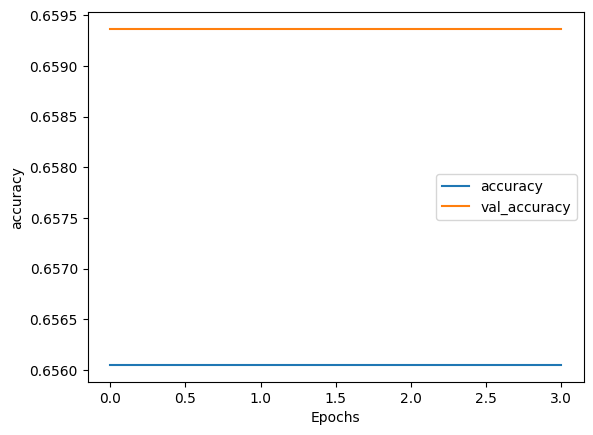

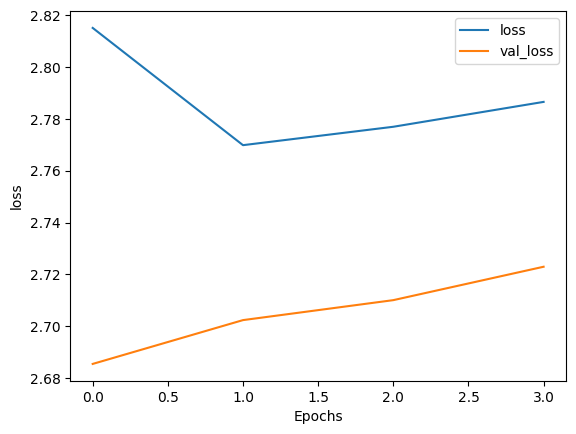

In [78]:
graph_plots(history, "accuracy")
graph_plots(history, "loss")

In [ ]:
#save model as 4class rnn model
model_path = "4class_lstm_model.model"
model.save(model_path)


INFO:tensorflow:Assets written to: 4class_lstm_model.model/assets


INFO:tensorflow:Assets written to: 4class_lstm_model.model/assets


55/55 [==============================] - 17s 309ms/step
AUC for task 0: 0.5
AUC for task 1: 0.5
AUC for task 2: 0.5
AUC for task 3: 0.5


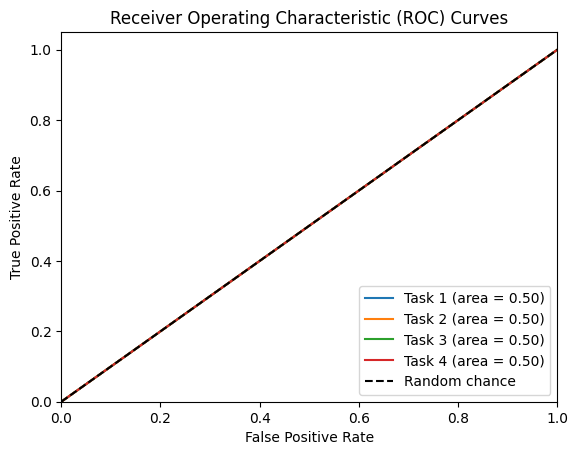

Average AUC: 0.5


In [81]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

y_pred = model.predict(X_test)
n_classes = y_test.shape[1]  # Make sure n_classes is defined

# Calculate AUC for each binary classification task and plot ROC curves
auc_scores = []

for i in range(n_classes):
    score = roc_auc_score(y_test[:, i], y_pred[:, i])  # Use a different variable name
    auc_scores.append(score)
    print(f"AUC for task {i}: {score}")

    fpr, tpr, thresholds = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)  
    plt.plot(fpr, tpr, label=f'Task {i+1} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

# Calculate the average AUC across all tasks
average_auc = np.mean(auc_scores)
print(f"Average AUC: {average_auc}")

In [ ]:
def find_best_threshold(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    # Calculate the J statistic for each threshold
    J = tpr - fpr
    # Find the index of the maximum J statistic
    index_of_max_J = np.argmax(J)
    best_threshold = thresholds[index_of_max_J]
    return best_threshold, J[index_of_max_J]

for i in range(n_classes):
    best_threshold, max_J = find_best_threshold(y_test[:, i], y_pred[:, i])
    print(f"Best threshold for task {i}: {best_threshold} with J statistic: {max_J}"
